In [1]:
!pip install swig
!pip install gymnasium[box2d]
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376134 sha256=3d4256c0c3e7a6cfce417fa9baa9834f0fc65bbb720645d205f13902e10c0b1f
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.3 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import dill

# Initialize the Bipedal Walker environment
env = gym.make('BipedalWalker-v3')#, render_mode="human")

# Get the observation and action space
obs = env.observation_space
act = env.action_space

print(f"Observation Space: {obs}")
print(f"Action Space: {act}")


Observation Space: Box([-3.1415927 -5.        -5.        -5.        -3.1415927 -5.
 -3.1415927 -5.        -0.        -3.1415927 -5.        -3.1415927
 -5.        -0.        -1.        -1.        -1.        -1.
 -1.        -1.        -1.        -1.        -1.        -1.       ], [3.1415927 5.        5.        5.        3.1415927 5.        3.1415927
 5.        5.        3.1415927 5.        3.1415927 5.        5.
 1.        1.        1.        1.        1.        1.        1.
 1.        1.        1.       ], (24,), float32)
Action Space: Box(-1.0, 1.0, (4,), float32)


In [3]:
#hyperparameters
OBS_BUCKETS = 9
ACT_BUCKETS = 9
EPISODES = 10000
REWARD_THRESHOLD = -200
GAMMA = 0.99
ALPHA = 0.01
EPSILON_INIT = 1.0
EPSILON_DECAY = 0.9999
EPSILON_MIN = 0.01

In [4]:
class QTableLearning:
    def __init__(self, env, episodes=EPISODES, gamma=GAMMA, alpha=ALPHA, epsilon_init=EPSILON_INIT, epsilon_decay=EPSILON_DECAY, epsilon_min=EPSILON_MIN,
                 obs_buckets=OBS_BUCKETS, act_buckets=ACT_BUCKETS, reward_threshold=REWARD_THRESHOLD, mode='uniform', render=False):
        """
        Initialize the Q-learning agent.

        Parameters:
        env (gym.Env): The environment to be used.
        obs_buckets (int): Number of discrete buckets per dimension in the observation space in uniform mode. Buckets per unity in range mode.
        act_buckets (int): Number of discrete actions per dimension in the action space.
        episodes (int): Number of episodes for training.
        gamma (float): Discount factor.
        alpha (float): Learning rate.
        epsilon (float): Initial exploration rate.
        epsilon_decay (float): Decay rate for epsilon.
        epsilon_min (float): Minimum value for epsilon.
        reward_threshold (float): Threshold for total reward to be considered a success.
        mode (str): Discretization mode, 'uniform' or 'range'.
        render (bool): Whether to render the environment.
        """
        self.env = env
        # discretization parameters
        self.obs_buckets = obs_buckets
        self.act_buckets = act_buckets

        # qtable initialization
        self.qtable = defaultdict(lambda: np.zeros(tuple([self.act_buckets] * self.env.action_space.shape[0])))

        # hyperparameters
        self.episodes = episodes
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon_init
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.reward_threshold = reward_threshold

        # select observation space discretization mode
        # in range mode, obs_buckets is the number of buckets per unit
        self.mode = mode

        self.render = render
        self.render_interval = 10

    def discretizeState(self, state):
        """
        Discretize the continuous observation state into discrete buckets based on the mode.

        Parameters:
        state (np.array): Continuous observation state.

        Returns:
        tuple: Discretized state.
        """
        if self.mode == 'uniform':
            discrete_state = np.round((state - self.env.observation_space.low) / (self.env.observation_space.high - self.env.observation_space.low) * (self.obs_buckets - 1)).astype(int)
        elif self.mode == 'range':
            discrete_state = []
            for i, val in enumerate(state):
                # compute the number of buckets for each dimension
                bucket_size = (self.env.observation_space.high[i] - self.env.observation_space.low[i]) * self.obs_buckets
                # make sure that there is at least one bucket for each dimension
                bucket_size = max(1, int(bucket_size))
                # discretize the dimension
                discrete_val = round((val - self.env.observation_space.low[i]) / (self.env.observation_space.high[i] - self.env.observation_space.low[i]) * (bucket_size - 1))
                discrete_state.append(discrete_val)
        else:
            raise ValueError(f"Invalid mode '{self.mode}'. Supported modes are 'uniform' and 'range'.")

        return tuple(discrete_state)

    def discretizeAction(self, action):
        """
        Discretize the continuous action into discrete buckets.

        Parameters:
        action (np.array): Continuous action.

        Returns:
        tuple: Discretized action.
        """
        discrete_action = np.round((action - self.env.action_space.low) / (self.env.action_space.high - self.env.action_space.low) * (self.act_buckets - 1)).astype(int)
        return tuple(discrete_action)

    def undiscretizeAction(self, action):
        """
        Convert a discrete action back into a continuous action.

        Parameters:
        action (tuple): Discretized action.

        Returns:
        tuple: Continuous action.
        """
        action = (np.array(action) / (self.act_buckets - 1)) * (self.env.action_space.high - self.env.action_space.low) + self.env.action_space.low
        return tuple(action)

    def epsilonGreedyStrategy(self, state):
        """
        Choose an action using the epsilon-greedy strategy.

        Parameters:
        state (tuple): Current discretized state.

        Returns:
        np.array: Chosen action.
        """
        if random.random() < self.epsilon:
            # Exploration: choose a random action
            action = np.random.randint(0, self.act_buckets, size=self.env.action_space.shape)
        else:
            # Exploitation: choose the action with the highest Q value
            q_values = self.qtable[state]
            flat_best_action_index = np.argmax(q_values)
            action = np.array(np.unravel_index(flat_best_action_index, q_values.shape))
        return action

    def updateQTable(self, state, action, reward, next_state):
        """
        Update the Q-table using the Q-learning update rule.

        Parameters:
        state (tuple): Current discretized state.
        action (tuple): Discretized action taken.
        reward (float): Reward received.
        next_state (tuple): Next discretized state.
        """
        q_sa = self.qtable[state][action]
        max_next_value = np.max(self.qtable[next_state]) if next_state in self.qtable else 0
        new_value = q_sa * (1 - self.alpha) + self.alpha * (reward + self.gamma * max_next_value)
        self.qtable[state][action] = new_value

    def learn(self):
        """
        Train the Q-learning agent over the specified number of episodes.
        """
        rewards = []  # List to store total rewards for each episode
        elapsed_times = []

        for episode in range(1, self.episodes + 1):
            total_reward = 0
            steps_taken = 0
            start_time = time.time()

            init = self.env.reset()[0]
            state = self.discretizeState(init)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            while total_reward > self.reward_threshold:
                action = self.epsilonGreedyStrategy(state)
                continuous_action = self.undiscretizeAction(action)
                next_state, reward, done, _, _ = self.env.step(continuous_action)

                if self.render and steps_taken % self.render_interval == 0:
                    self.env.render()

                next_state = self.discretizeState(next_state)
                action = tuple(action)
                self.updateQTable(state, action, reward, next_state)
                total_reward += reward
                state = next_state
                steps_taken += 1

                if done:
                    break

            end_time = time.time()
            elapsed_time = end_time - start_time
            elapsed_times.append(elapsed_time)
            rewards.append(total_reward)  # Store total reward for this episode
            print(f"Episode {episode}/{self.episodes}, Total Reward: {total_reward}, Elapsed Time: {elapsed_time}")

        self.env.close()
        max_reward = max(rewards)  # Calculate the maximum reward
        print(f"Maximum Reward: {max_reward}")
        return self.qtable, rewards, elapsed_times


In [6]:
window_size = 100

# Function to calculate the moving average using np.mean
def moving_average(data, window_size=window_size):
    moving_averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        window_average = np.mean(window)
        moving_averages.append(window_average)
    return moving_averages

mode = 'range'


Episode 1/2, Total Reward: -200.01673606310544, Elapsed Time: 3.148768186569214
Episode 2/2, Total Reward: -105.6584070947015, Elapsed Time: 0.053276777267456055
Maximum Reward: -105.6584070947015


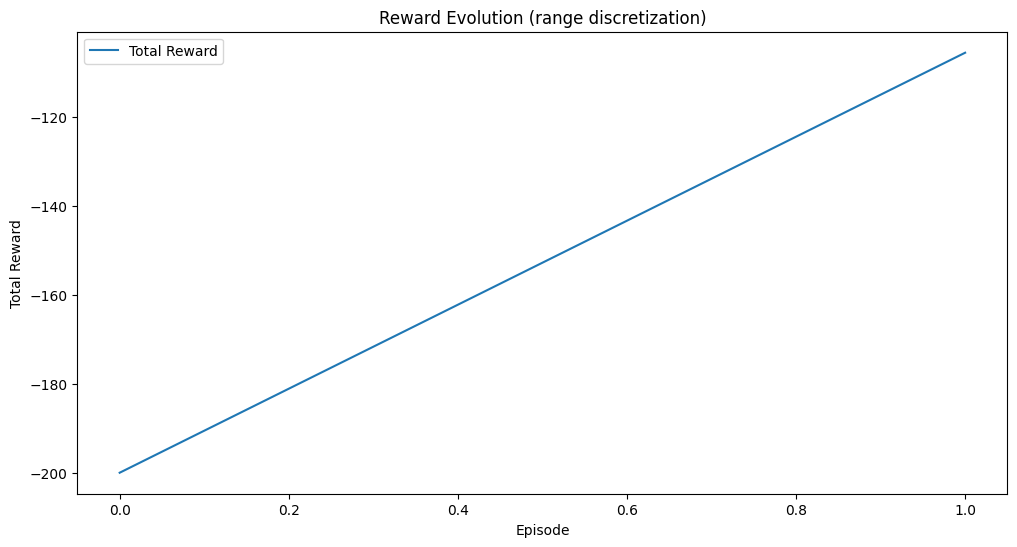

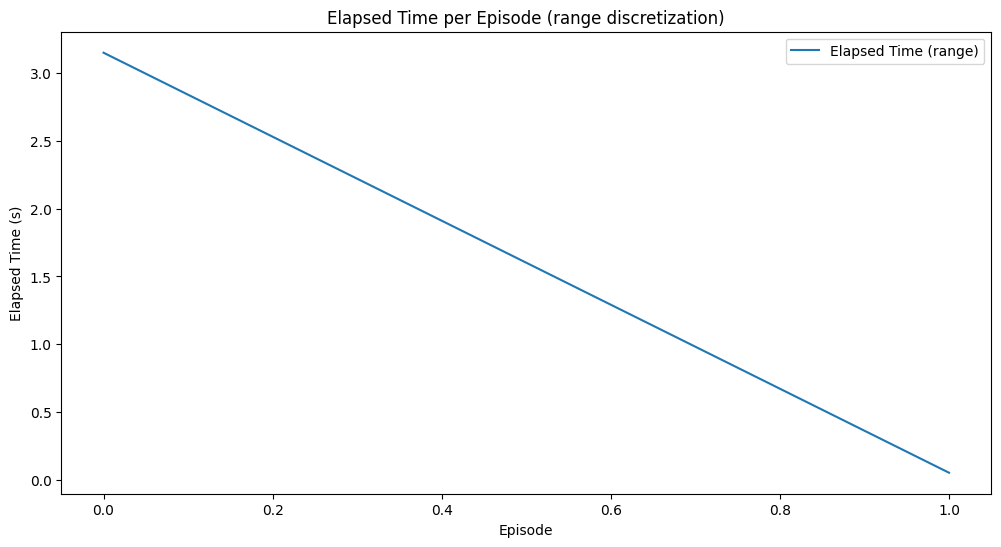

In [7]:
if mode == 'uniform':
    q_learning = QTableLearning(env, mode=mode)  # Initialize Q-learning with uniform discretization
elif mode == 'range':
    q_learning = QTableLearning(env, obs_buckets=1, mode=mode)  # Initialize Q-learning with range-based discretization
if mode == 'uniform' or mode == 'range':
    file_name = f'qtable_{mode}.dill'

    qtable, rewards, elapsed_times = q_learning.learn()

    # Save the Q-table
    with open(f'qtable_{mode}.dill', 'wb') as f:
        dill.dump(qtable, f)

    # Plot rewards
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Total Reward')
    if len(rewards) >= window_size:
        plt.plot(range(window_size, len(rewards) + 1), moving_average(rewards), label='Moving Average (100 episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title(f'Reward Evolution ({mode} discretization)')
    plt.legend()
    plt.savefig(f'Rewards Evolutions {mode}.png')

    # Plot elapsed times
    plt.figure(figsize=(12, 6))
    plt.plot(elapsed_times, label=f'Elapsed Time ({mode})')
    plt.xlabel('Episode')
    plt.ylabel('Elapsed Time (s)')
    plt.title(f'Elapsed Time per Episode ({mode} discretization)')
    plt.legend()
    plt.savefig(f'Elapsed Times {mode}.png')

Test Episode 1/2, Total Reward: -101.60642534028801
Test Episode 2/2, Total Reward: -101.79683253739216


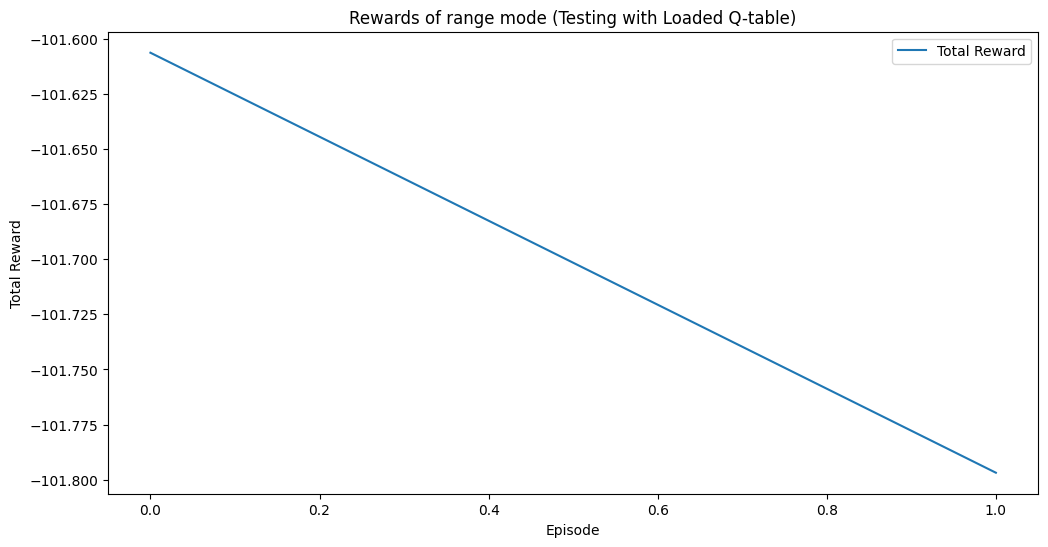

In [8]:
import dill
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt


def load_qtable(filename):
    with open(filename, 'rb') as f:
        qtable = dill.load(f)
    return qtable


mode = 'range'
act_buckets = 9
obs_buckets = 9

if mode == 'range':
    obs_buckets = 1

filename = f'qtable_{mode}.dill'
qtable = load_qtable(filename)
env = gym.make("BipedalWalker-v3", render_mode = 'human')


def test_qtable(qtable, env, episodes=100, reward_threshold = -1000, steps_threshold = 10000, render=True):
    rewards = []
    render_freq = 10

    for episode in range(1, episodes + 1):
        total_reward = 0
        state = env.reset()[0]
        state = discretizeState(state)
        steps = 0
        done = False

        while not done and total_reward > reward_threshold and steps < steps_threshold:
            flat_best_action_index = np.argmax(qtable[state])
            action = np.array(np.unravel_index(flat_best_action_index, qtable[state].shape))
            continuous_action = undiscretizeAction(action)
            next_state, reward, done, _, _ = env.step(continuous_action)

            if render and steps % render_freq == 0:
                env.render()

            next_state = discretizeState(next_state)
            total_reward += reward
            state = next_state
            steps += 1


        rewards.append(total_reward)
        print(f"Test Episode {episode}/{episodes}, Total Reward: {total_reward}")

    env.close()
    return rewards


def discretizeState(state):
    """
    Discretize the continuous observation state into discrete buckets based on the mode.

    Parameters:
    state (np.array): Continuous observation state.

    Returns:
    tuple: Discretized state.
    """
    if mode == 'uniform':
        discrete_state = np.round((state - env.observation_space.low) / (env.observation_space.high - env.observation_space.low) * (obs_buckets - 1)).astype(int)
    elif mode == 'range':
        discrete_state = []
        for i, val in enumerate(state):
            # compute the number of buckets for each dimension
            bucket_size = (env.observation_space.high[i] - env.observation_space.low[i]) * obs_buckets
            # make sure that there is at least one bucket for each dimension
            bucket_size = max(1, int(bucket_size))
            # discretize the dimension
            discrete_val = round((val - env.observation_space.low[i]) / (env.observation_space.high[i] - env.observation_space.low[i]) * (bucket_size - 1))
            discrete_state.append(discrete_val)
    else:
        raise ValueError(f"Invalid mode '{mode}'. Supported modes are 'uniform' and 'range'.")

    return tuple(discrete_state)

def discretizeAction(action):
    """
    Discretize the continuous action into discrete buckets.

    Parameters:
    action (np.array): Continuous action.

    Returns:
    tuple: Discretized action.
    """
    discrete_action = np.round((action - env.action_space.low) / (env.action_space.high - env.action_space.low) * (act_buckets - 1)).astype(int)
    return tuple(discrete_action)

def undiscretizeAction(action):
    """
    Convert a discrete action back into a continuous action.

    Parameters:
    action (tuple): Discretized action.

    Returns:
    tuple: Continuous action.
    """
    action = (np.array(action) / (act_buckets - 1)) * (env.action_space.high - env.action_space.low) + env.action_space.low
    return tuple(action)


test_rewards = test_qtable(qtable, env)

plt.figure(figsize=(12, 6))
plt.plot(test_rewards, label='Total Reward')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title(f'Rewards of {mode} mode (Testing with Loaded Q-table)')
plt.legend()
plt.savefig(f'Rewards {mode}.png')
